# NQ&A Prediction

In [15]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf

from scripts import tf2_0_baseline_w_bert_translated_to_tf2_0 as tf2baseline # Oliviera's script
from scripts.tf2_0_baseline_w_bert_translated_to_tf2_0 import Answer, AnswerType
from scripts import bert_modeling as modeling
from scripts import bert_tokenization
from scripts import albert
from scripts import albert_tokenization
from scripts.models import build_model

import collections
from collections import OrderedDict, namedtuple
import copy
import itertools
import json
import absl
import sys
import os
import warnings

In [16]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(absl.flags.FLAGS)

flags = absl.flags

### Main Model Flags ###

flags.DEFINE_string(
    "model", "bert",
    "The name of model to use. Choose from ['bert', 'albert'].")

flags.DEFINE_string(
    "config_file", "models/bert_joint_baseline/bert_config.json",
    "The config json file corresponding to the pre-trained BERT/ALBERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("vocab_file", "models/bert_joint_baseline/vocab-nq.txt",
                    "The vocabulary file that the ALBERT/BERT model was trained on.")

flags.DEFINE_string(
    "init_checkpoint", "models/bert_joint_baseline/tf2_bert_joint.ckpt",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer(
    "max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer("predict_batch_size", 1,
                     "Total batch size for predictions.")

### Second Model Flags ###

flags.DEFINE_string(
    "second_model", "albert",
    "The name of model to use. Choose from ['albert', 'bert'].")

flags.DEFINE_string(
    "second_config_file", "models/albert_xxl/config.json",
    "The config json file corresponding to the pre-trained BERT/ALBERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("second_vocab_file", "models/albert_xxl/vocab/modified-30k-clean.model",
                    "The vocabulary file that the ALBERT/BERT model was trained on.")

flags.DEFINE_string(
    "second_init_checkpoint", "models/albert_xxl/albert_finetuned.h5",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer(
    "second_max_seq_length", 384,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "second_batch_size", 1,
    "Batch size when running verifier predictions.")

### Other Flags ###

flags.DEFINE_string(
    "output_dir", "output/",
    "The output directory where the model checkpoints will be written.")

flags.DEFINE_string(
    "train_file", "data/simplified-nq-dev.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")

flags.DEFINE_string(
    "log_dir", "logs/",
    "Where logs, specifically Tensorboard logs, will be saved to.")

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

flags.DEFINE_integer(
    "doc_stride", 128,
    "When splitting up a long document into chunks, how much stride to "
    "take between chunks.")

flags.DEFINE_integer(
    "max_query_length", 64,
    "The maximum number of tokens for the question. Questions longer than "
    "this will be truncated to this length.")

flags.DEFINE_bool("do_train", False, "Whether to run training.")

flags.DEFINE_bool("do_predict", True, "Whether to run eval on the dev set.")

flags.DEFINE_integer(
    "max_answer_length", 30,
    "The maximum length of an answer that can be generated. This is needed "
    "because the start and end predictions are not conditioned on one another.")

flags.DEFINE_float(
    "include_unknowns", 1.0,
    "If positive, probability of including answers of type `UNKNOWN`.")

absl.flags.DEFINE_string(
    "gcp_project", None,
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

# TODO(Edan): Look at nested contents too at some point
# Around 5% of long answers are nested, and around 50% of questions have
# long answers
# This means that this setting alone restricts us from a correct answer
# around 2.5% of the time
flags.DEFINE_boolean(
    "skip_nested_contexts", True,
    "Completely ignore context that are not top level nodes in the page.")

flags.DEFINE_integer("max_contexts", 48,
                     "Maximum number of contexts to output for an example.")

flags.DEFINE_integer(
    "max_position", 50,
    "Maximum context position for which to generate special tokens.")

flags.DEFINE_integer(
    "n_examples", 200,
    "Number of examples to read from files.")

flags.DEFINE_boolean(
    "test_post_processing", True,
    "If true, training data will be predicted for instead of eval data,"
    "and the predictions will be used to tune the post processing algorithm.")

flags.DEFINE_integer(
    "tokens_per_small_example", 105*10, # On average about 10 features
    "The amount of tokens allowed on average for an example to be considered "
    "small. Small examples are run directly through ALBERT-xxl.")

### Currently Not In Use ###

flags.DEFINE_integer(
    "max_features_per_small_example", 15,
    "The amount of features allowed for a small example before being truncated.")

flags.DEFINE_integer(
    "max_features_per_example", 65,
    "The amount of features allowed for an example before being truncated.")

## Special flags - do not change

flags.DEFINE_string(
    "predict_file", "/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl",
    "NQ json for predictions. E.g., dev-v1.1.jsonl.gz or test-v1.1.jsonl.gz")
flags.DEFINE_boolean("logtostderr", True, "Logs to stderr")
flags.DEFINE_boolean("undefok", True, "it's okay to be undefined")
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_string('HistoryManager.hist_file', '', 'kernel')

FLAGS = flags.FLAGS
FLAGS(sys.argv) # Parse the flags

N_TRAIN_EXAMPLES = 307373

# Data Utility Functions

In [17]:
def read_partial_nq_examples(input_file, is_training, n=-1, from_back=False):
    """Read a NQ json file into a list of NqExample."""
    input_paths = tf.io.gfile.glob(input_file)
    input_data = []

    def _open(path):
        if path.endswith(".gz"):
            return gzip.GzipFile(fileobj=tf.io.gfile.GFile(path, "rb"))
        else:
            return tf.io.gfile.GFile(path, "r")

    n_skip = 0
    if from_back and n > 0:
        n_skip = N_TRAIN_EXAMPLES - n

    for path in input_paths:
        absl.logging.info("Reading: %s", path)
        with _open(path) as input_file:
            for _ in range(n_skip):
                input_file.readline()
            for index, line in enumerate(input_file):
                if n > -1 and index >= n:
                        break
                input_data.append(tf2baseline.create_example_from_jsonl(line))

    examples = []
    for entry in input_data:
        examples.extend(tf2baseline.read_nq_entry(entry, is_training))
    return examples

tf2baseline.read_nq_examples = read_partial_nq_examples

def read_partial_candidates_from_one_split(input_path, n=-1, from_back=False):
    """Read candidates from a single jsonl file."""
    candidates_dict = {}
    if input_path.endswith(".gz"):
        with gzip.GzipFile(fileobj=tf.io.gfile.GFile(input_path, "rb")) as input_file:
            absl.logging.info("Reading examples from: %s", input_path)

            n_skip = 0
            if from_back and n > 0:
                n_skip = N_TRAIN_EXAMPLES - n

            for _ in range(n_skip):
                input_file.readline()
        
            for index, line in enumerate(input_file):
                if n > -1 and index >= n:
                        break

                e = json.loads(line)
                candidates_dict[e["example_id"]] = e["long_answer_candidates"]
    else:
        with tf.io.gfile.GFile(input_path, "r") as input_file:
            absl.logging.info("Reading examples from: %s", input_path)
            
            n_skip = 0
            if from_back and n > 0:
                n_skip = N_TRAIN_EXAMPLES - n

            for _ in range(n_skip):
                input_file.readline()
            
            for index, line in enumerate(input_file):
                if n > -1 and index >= n:
                        break
                        
                e = json.loads(line)
                candidates_dict[e["example_id"]] = e["long_answer_candidates"]
                
    return candidates_dict

tf2baseline.read_candidates_from_one_split = read_partial_candidates_from_one_split

def read_partial_candidates(input_pattern, n=-1, from_back=False):
    """Read candidates with real multiple processes."""
    input_paths = tf.io.gfile.glob(input_pattern)

    if from_back and n > 0:
        assert len(input_paths) == 1

    final_dict = {}
    for i, input_path in enumerate(input_paths):
        final_dict.update(tf2baseline.read_candidates_from_one_split(input_path, n=n-len(final_dict.keys()),
                                                                     from_back=from_back))
        if len(final_dict.keys()) >= n:
                break

    return final_dict

tf2baseline.read_candidates = read_partial_candidates

def raw_data_generator(path, chunk_size=1000, from_back=False):
        """Reads raw JSON examples to a DataFrame"""
        curr_pos = 0
        last_line = False
        with open(path, 'rt') as f:
                
                n_skip = 0
                if from_back and chunk_size > 0:
                    n_skip = N_TRAIN_EXAMPLES - chunk_size

                for _ in range(n_skip):
                    f.readline()
            
                while not last_line:
                        df = []
                        for i in range(curr_pos, curr_pos+chunk_size):
                                line = f.readline()
                                if line is None:
                                        last_line = True
                                        break
                                df.append(json.loads(line))
                        curr_pos = i + 1
                        yield pd.DataFrame(df)

In [24]:
name_to_features = {
    "unique_ids": tf.io.FixedLenFeature([], tf.int64),
    "input_ids": tf.io.FixedLenFeature([FLAGS.max_seq_length], tf.int64),
    "input_mask": tf.io.FixedLenFeature([FLAGS.max_seq_length], tf.int64),
    "segment_ids": tf.io.FixedLenFeature([FLAGS.max_seq_length], tf.int64),
}
if FLAGS.do_train:
    name_to_features["start_positions"] = tf.io.FixedLenFeature([], tf.int64)
    name_to_features["end_positions"] = tf.io.FixedLenFeature([], tf.int64)
    name_to_features["answer_types"] = tf.io.FixedLenFeature([], tf.int64)

def decode_record(record, name_to_features):
    """Decodes a record to a TensorFlow example."""
    example = tf.io.parse_single_example(serialized=record, features=name_to_features)

    # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
    # So cast all int64 to int32.
    for name in list(example.keys()):
        t = example[name]
        if t.dtype == tf.int64:
            t = tf.cast(t, dtype=tf.int32)
        example[name] = t

    return example

def data_generator(eval_filename, batch_size=32, n_samples=-1, seed=42):
    """The actual input function."""
    
    dataset = tf.data.TFRecordDataset(eval_filename)
    if FLAGS.do_train:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(buffer_size=5000, seed=seed)
        
    dataset = dataset.map(lambda r: decode_record(r, name_to_features))
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=False)
    
    data_iter = iter(dataset)
    sample_idx = 0
    while sample_idx < n_samples or n_samples == -1:
        try:
            examples = next(data_iter)
        except StopIteration:
            break
            
        cutoff_amt = batch_size
        if n_samples > -1:
            cutoff_amt = min(cutoff_amt, n_samples - sample_idx)
        sample_idx += cutoff_amt
    
        for k, v in examples.items():
            examples[k] = v[:cutoff_amt]
        
        inputs = {
            # 'unique_id': examples['unique_ids'],
            'input_ids': examples['input_ids'],
            'input_mask': examples['input_mask'],
            'segment_ids': examples['segment_ids']
        }

        if FLAGS.do_train:
            targets = {
                'tf_op_layer_start_logits': examples['start_positions'],
                'tf_op_layer_end_logits': examples['end_positions'],
                'ans_type_logits': examples['answer_types'],
            }

            yield inputs, targets
        else:
            yield inputs

## Functions for Computing Answers from Logits

In [8]:
# Sigmoid
def logits_to_probs(x):
    return np.exp(x) / (np.exp(x) + 1)

def get_candidate_span(entry):
    return (entry['candidates'][entry['candidate_idx']]['start_token'],
            entry['candidates'][entry['candidate_idx']]['end_token'])

def check_entry_in_candidates(entry):
    """Checks if the entry start and ending tokens fall into a candidate.
        Returns the candidate index, or -1 if none is found."""
    if not FLAGS.skip_nested_contexts:
        raise NotImplementedError('Nested contexts have not been implemented for predictions yet!')
    else:
        for cand_idx, candidate in enumerate(entry['candidates']):
            if not candidate['top_level']:
                continue
            if entry['orig_start'] >= candidate['start_token'] and \
                entry['orig_end'] <= candidate['end_token']:
                return cand_idx
    return -1

def compute_answers(preds, candidates_dict, features,
                    examples, id_to_examples, weights={},
                    invalid_input_ids=[]):
    default_weights = {
        'ans_type_conf_weight': 0.4,
        'start_pos_conf_weight': 0.3,
        'end_pos_conf_weight': 0.3,
        'conf_bias': 0.0,
        'conf_threshold': 0.98
    }
    
    for k, v in default_weights.items():
        if k not in weights:
            weights[k] = v
    
    ### Get variables needed for post processing ###
    start_token_probs = logits_to_probs(preds[0])
    end_token_probs = logits_to_probs(preds[1])
    ans_type_probs = logits_to_probs(preds[2])
    candidates_dict = {int(k): v for k, v in candidates_dict.items()}

    ### Create doc span groups ###
    
    doc_span_groups = {}
    for i, feature in enumerate(features):
        example_idx = feature.example_index
        if example_idx not in doc_span_groups:
            doc_span_groups[example_idx] = []

        group_data = {
            'start_tokens_probs': start_token_probs[i],
            'end_tokens_probs': end_token_probs[i],
            'ans_type_probs': ans_type_probs[i],
            'candidates': candidates_dict[example_idx],
            'feature': features[i],
            'doc_tokens_map': id_to_examples[example_idx].doc_tokens_map
        }

        doc_span_groups[example_idx].append(group_data)
    
    ### Compute answers ###
        
    answers = {} # Maps example_ids to long and short answers
    for example_id, group in doc_span_groups.items():
        example = id_to_example[example_id]
        example.n_features = len(group)
        doc_to_orig = example.doc_tokens_map
        
        assert doc_to_orig is not None
        
        # Reverse doc_to_orig to create orig_to_doc
        orig_to_doc = {}
        for doc_token_idx, orig_tok_idx in enumerate(doc_to_orig):
            orig_to_doc[orig_tok_idx] = doc_token_idx
        orig_to_doc[-1] = -1
        example.orig_to_doc = orig_to_doc
        
        # This loop just gathers the non-unknown, valid predictions
        valid_entries = []
        for entry in group:
            try:
                # Converting logits to answer values
                entry['start_token_idx'] = np.argmax(entry['start_tokens_probs'])
                entry['end_token_idx'] = np.argmax(entry['end_tokens_probs'])
                entry['ans_type_idx'] = np.argmax(entry['ans_type_probs'])

                entry['start_pos_prob'] = entry['start_tokens_probs'][entry['start_token_idx']]
                entry['end_pos_prob'] = entry['end_tokens_probs'][entry['end_token_idx']]
                entry['ans_type_prob'] = entry['ans_type_probs'][entry['ans_type_idx']]

                # Calculating probability of the chosen answer type
                entry['prob'] = weights['conf_bias'] + \
                                entry['start_pos_prob'] * weights['start_pos_conf_weight'] + \
                                entry['end_pos_prob'] * weights['end_pos_conf_weight'] + \
                                entry['ans_type_prob'] * weights['ans_type_conf_weight']

                # Filter out entries with invalid answers
                if entry['end_token_idx'] < entry['start_token_idx'] or \
                    (entry['end_token_idx'] - entry['start_token_idx'] > FLAGS.max_answer_length and \
                     entry['ans_type_idx'] == AnswerType.SHORT) or \
                    entry['feature'].segment_ids[entry['start_token_idx']] == 0 or \
                    entry['feature'].segment_ids[entry['end_token_idx']] == 0 or \
                    entry['feature'].input_mask[entry['start_token_idx']] == 0 or \
                    entry['feature'].input_mask[entry['end_token_idx']] == 0 or \
                    entry['feature'].input_ids[entry['start_token_idx']] in invalid_input_ids or \
                    entry['feature'].input_ids[entry['end_token_idx']] in invalid_input_ids or \
                    entry['ans_type_idx'] == AnswerType.UNKNOWN or \
                    entry['prob'] < weights['conf_threshold']:
                    continue
                    
                # Getting indices of tokens in original document
                tok_to_orig_map = entry['feature'].token_to_orig_map
                
                entry['orig_start'] = tok_to_orig_map[entry['start_token_idx']]
                entry['orig_end'] = tok_to_orig_map[entry['end_token_idx']] + 1

                entry['doc_tokens_start_idx'] = -1
                entry['doc_tokens_end_idx'] = -1

                # Getting indices of tokens in preprocessed document
                if entry['orig_start'] in orig_to_doc:
                    entry['doc_tokens_start_idx'] = orig_to_doc[entry['orig_start']]
                else:
                    # I'm not sure if this resolution works
#                     print('Resolving orig_to_doc missing index, but resolution method may be flawed!')
                    target = entry['orig_start']
                    for key in sorted(orig_to_doc.keys()):
                        if key > target:
                            entry['doc_tokens_start_idx'] = orig_to_doc[key]
                            break

                if entry['orig_end'] in orig_to_doc:
                    entry['doc_tokens_end_idx'] = orig_to_doc[entry['orig_end'] - 1] + 1
                else:
                    # I'm not sure if this resolution works
#                     print('Resolving orig_to_doc missing index, but resolution method may be flawed!')
                    target = entry['orig_end'] - 1
                    for key in sorted(orig_to_doc.keys(), reverse=True):
                        if key < target:
                            entry['doc_tokens_end_idx'] = orig_to_doc[key] + 1
                            break

                if entry['doc_tokens_start_idx'] == -1 or entry['doc_tokens_end_idx'] == -1 \
                   or entry['doc_tokens_end_idx'] == 0:
                    warnings.warn('Original to document index mapping could not be resolved!')
                    continue

                entry['candidate_idx'] = check_entry_in_candidates(entry)
                if entry['candidate_idx'] == -1:
                    continue

                valid_entries.append(entry)
            except:
                warning.warn("Unexpected while parsing features:", sys.exc_info()[0])

        long_answer = None
        short_answer = None
        doc_tokens_span = None
        ordered_entries = None
            
        if len(valid_entries) > 0:
            # TODO(Edan): I think I should probably prioritize short answers
            # over long answers because both can be right, but most long answer
            # also have short answers
            # I could also look at if other probabilities are also high,
            # ideally only a single entry should have a high logit
            # Ammend: not only one entry, but one and the ones near it
            ordered_entries = sorted(valid_entries, key=lambda e: e['prob'], reverse=True)
            best_entry = ordered_entries[0]
            if best_entry['ans_type_idx'] == AnswerType.LONG:
                long_answer = get_candidate_span(best_entry)
            elif best_entry['ans_type_idx'] == AnswerType.SHORT:
                long_answer = get_candidate_span(best_entry)
                short_answer = (best_entry['orig_start'], best_entry['orig_end'])
            elif best_entry['ans_type_idx'] == AnswerType.YES:
                long_answer = get_candidate_span(best_entry)
                short_answer = 'YES'
            elif best_entry['ans_type_idx'] == AnswerType.NO:
                long_answer = get_candidate_span(best_entry)
                short_answer = 'NO'
            else:
                raise ValueError('Entry should not have AnswerType UNKNOWN or other!')
                
            doc_tokens_start = best_entry['doc_tokens_start_idx']
            doc_tokens_end = best_entry['doc_tokens_end_idx']
            doc_tokens_span = (doc_tokens_start, doc_tokens_end)
        
        answers[example_id] = {'long_answer': long_answer,
                               'short_answer': short_answer,
                               'doc_tokens_span': doc_tokens_span,
                               'ordered_entries': ordered_entries}

    return answers

def get_actual_answers(file_path, n, from_back=False):
    raw_generator = raw_data_generator(file_path, n, from_back)
    raw_data = next(raw_generator)
    
    actual_answers = {}
    for _, entry in raw_data.iterrows():
        long_answer = entry['annotations'][0]['long_answer']
        short_answers = entry['annotations'][0]['short_answers']
        
        la_spans = []
        if long_answer['start_token'] != -1 and long_answer['end_token'] != -1:
            la_spans = [(long_answer['start_token'], long_answer['end_token'])]
        
        sa_spans = []
        for short_answer in short_answers:
            sa_spans.append((short_answer['start_token'], short_answer['end_token']))
            
        if entry['annotations'][0]['yes_no_answer'] != 'NONE':
            sa_spans.append(entry['annotations'][0]['yes_no_answer'])
        
        answer_entry = {
            'long_answers': la_spans,
            'short_answers': sa_spans
        }
        actual_answers[entry['example_id']] = answer_entry
        
    return actual_answers

# Preprocessing for the Second Model

In [22]:
def convert_partial_example(example, start_idx, end_idx, tokenizer, is_training, lowercase=True, fit_span=True):
    """Converts a single NqExample into a list of InputFeatures.
    
    Start and end indices are given by the preprocessed document indices.
    """
    # QUERY
    query_tokens = []
    query_tokens.append("[Q]")
    query_tokens.extend(tf2baseline.tokenize(tokenizer, example.questions[-1]))
    if len(query_tokens) > FLAGS.max_query_length:
        query_tokens = query_tokens[-FLAGS.max_query_length:]

    # The -3 accounts for [CLS], [SEP] and [SEP]
    max_tokens_for_doc = FLAGS.max_seq_length - len(query_tokens) - 3
    
    part_doc_tokens = example.doc_tokens[start_idx:end_idx]
    part_doc_tokens_map = None
    if example.doc_tokens_map:
        part_doc_tokens_map = example.doc_tokens_map[start_idx:end_idx]
    
    tok_to_orig_index = [] # Tokenized doc to original doc
    orig_to_tok_index = [-1] * start_idx # Preprocessed doc to tokenized doc mapping
    all_doc_tokens = []
    features = []
    for (i, token) in enumerate(part_doc_tokens, start_idx):
        if lowercase and not (token.startswith('[') and token.endswith(']')):
            token = token.lower()
        
        orig_to_tok_index.append(len(all_doc_tokens))
        sub_tokens = tf2baseline.tokenize(tokenizer, token)
        tok_to_orig_index.extend([i] * len(sub_tokens))
        all_doc_tokens.extend(sub_tokens)

    if fit_span:
        # Even though it's a partial example, we might as well fill up the doc span
        i = end_idx
        while i < len(example.doc_tokens):
            if len(all_doc_tokens) == max_tokens_for_doc or \
               (len(all_doc_tokens) > max_tokens_for_doc and \
               (len(all_doc_tokens) - max_tokens_for_doc) % 128 == 0):
                break

            token = example.doc_tokens[i]
            if lowercase and not (token.startswith('[') and token.endswith(']')):
                token = token.lower()

            orig_to_tok_index.append(len(all_doc_tokens))
            sub_tokens = tf2baseline.tokenize(tokenizer, token)
            for sub_token in sub_tokens:
                tok_to_orig_index.append(i)
                all_doc_tokens.append(sub_token)
                if len(all_doc_tokens) == max_tokens_for_doc or \
                   (len(all_doc_tokens) > max_tokens_for_doc and \
                   (len(all_doc_tokens) - max_tokens_for_doc) % 128 == 0):
                    break
            i += 1
        
    orig_to_tok_index.extend([-1] * (len(example.doc_tokens) - len(all_doc_tokens)))

    # `tok_to_orig_index` maps wordpiece indices to indices of whitespace
    # tokenized word tokens in the contexts. The word tokens might themselves
    # correspond to word tokens in a larger document, with the mapping given
    # by `doc_tokens_map`.
    if example.doc_tokens_map:
        tok_to_orig_index = [
            example.doc_tokens_map[index] for index in tok_to_orig_index
        ]

    # We can have documents that are longer than the maximum sequence length.
    # To deal with this we do a sliding window approach, where we take chunks
    # of up to our max length with a stride of `doc_stride`.
    _DocSpan = namedtuple(  # pylint: disable=invalid-name
        "DocSpan", ["start", "length"])
    doc_spans = []
    start_offset = 0
    while start_offset < len(all_doc_tokens):
        length = len(all_doc_tokens) - start_offset
        length = min(length, max_tokens_for_doc)
        doc_spans.append(_DocSpan(start=start_offset, length=length))
        if start_offset + length == len(all_doc_tokens):
            break
        start_offset += min(length, FLAGS.doc_stride)
    
    for (doc_span_index, doc_span) in enumerate(doc_spans):
        tokens = []
        token_to_orig_map = {}
        token_is_max_context = {}
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        tokens.extend(query_tokens)
        segment_ids.extend([0] * len(query_tokens))
        tokens.append("[SEP]")
        segment_ids.append(0)

        for i in range(doc_span.length):
            split_token_index = doc_span.start + i
            token_to_orig_map[len(tokens)] = tok_to_orig_index[split_token_index]

            is_max_context = tf2baseline.check_is_max_context(doc_spans, doc_span_index,
                split_token_index)
            token_is_max_context[len(tokens)] = is_max_context
            tokens.append(all_doc_tokens[split_token_index])
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)
        assert len(tokens) == len(segment_ids)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (FLAGS.max_seq_length - len(input_ids))
        input_ids.extend(padding)
        input_mask.extend(padding)
        segment_ids.extend(padding)

        assert len(input_ids) == FLAGS.max_seq_length
        assert len(input_mask) == FLAGS.max_seq_length
        assert len(segment_ids) == FLAGS.max_seq_length

        start_position = -1
        end_position = -1
        answer_type = -1
        answer_text = ""

        feature = tf2baseline.InputFeatures(
            unique_id=-1,
            example_index=-1,
            doc_span_index=doc_span_index,
            tokens=tokens,
            token_to_orig_map=token_to_orig_map,
            token_is_max_context=token_is_max_context,
            input_ids=input_ids,
            input_mask=input_mask,
            segment_ids=segment_ids,
            start_position=start_position,
            end_position=end_position,
            answer_text=answer_text,
            answer_type=answer_type)

        features.append(feature)

    return features

def convert_partial_examples_to_features(examples, ranges, tokenizer, is_training, output_fn):
    """Converts a list of NqExamples into InputFeatures."""
    num_spans_to_ids = collections.defaultdict(list)

    for example, idx_range in zip(examples, ranges):
        example_index = example.example_id
        features = convert_partial_example(example, idx_range[0], idx_range[1], tokenizer, is_training)
        num_spans_to_ids[len(features)].append(example.qas_id)

        for feature in features:
            feature.example_index = example_index
            feature.unique_id = feature.example_index + feature.doc_span_index
            output_fn(feature)

    return num_spans_to_ids

### Answer Types
- UNKNOWN = 0
- YES = 1
- NO = 2
- SHORT = 3
- LONG = 4

# Functions for Computing the Micro-F1 Score

In [9]:
def score_preds(actual_answers, pred_answers):
    if set(actual_answers.keys()) != set(answers.keys()):
        raise ValueError('Actual answers and answers must contain the same example_id keys!')
    
    TP = 0 # True positives
    FP = 0 # False positives
    FN = 0 # False negatives
    
    FP_NA = 0 # False positives where there was no answer
    FP_WA = 0 # False positives where an answer existed
    for example_id in actual_answers.keys():
        actual_las = actual_answers[example_id]['long_answers']
        actual_sas = actual_answers[example_id]['short_answers']
        
        pred_la = pred_answers[example_id]['long_answer']
        pred_sa = pred_answers[example_id]['short_answer']
        
        if pred_la in actual_las:
            TP += 1
        elif pred_la and pred_la not in actual_las:
            FP += 1
            if actual_las:
                FP_WA += 1
            else:
                FP_NA += 1
        elif not pred_la and actual_las:
            FN += 1
            
        if pred_sa in actual_sas:
            TP += 1
        elif pred_sa and pred_sa not in actual_las:
            FP += 1
            if actual_sas:
                FP_WA += 1
            else:
                FP_NA += 1
        elif not pred_sa and actual_sas:
            FN += 1

    details = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'FP_WA': FP_WA,
        'FP_NA': FP_NA
    }
    
    if TP == 0:
        return 0, 0, 0, details
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    micro_f1 = 2 * precision * recall / (precision + recall)
    return micro_f1, recall, precision, details

In [10]:
def long_annotations(example):
    longs = [('%s:%s' % (l['start_token'],l['end_token']))
                for l in [a['long_answer'] for a in example['annotations']]
                if not l['candidate_index'] == -1
            ]
    return longs #list of long annotations

def short_annotations(example):
    shorts = [('%s:%s' % (s['start_token'],s['end_token']))
                  for s in 
                  # sum(list_of_lists, []) is not very efficient gives an easy flat map for short lists
                  sum([a['short_answers'] for a in example['annotations']], [])
             ]
    return shorts #list of short annotations

def yes_nos(example):
    return [
        yesno for yesno in [a['yes_no_answer'] for a in example['annotations']]
        if not yesno == 'NONE'
    ]

class Score():
    def __init__(self):
        self.TP = 0
        self.FP = 0
        self.FN = 0
        self.TN = 0
    def F1(self):
        return 2 * self.TP / (2 * self.TP + self.FP + self.FN)
    def increment(self, prediction, annotations, yes_nos):
        if prediction in yes_nos:
            print(prediction, yes_nos)
            self.TP += 1
        elif len(prediction) > 0:
            if prediction in annotations:
                self.TP += 1
            else:
                self.FP += 1
        elif len(annotations) == 0:
            self.TN += 1
        else:
            self.FN +=1
    def scores(self):
        recall = 
        return 'TP = {}   FP = {}   FN = {}   TN = {}   Recall = {:.3f}  Precision = {:.3f}   F1 = {:.3f}'.format(
            self.TP, self.FP, self.FN, self.TN, recall, precision, self.F1())

def score_preds_2(raw_examples, answers):
    long_score = Score()
    short_score = Score()
    total_score = Score()

    for example in raw_examples:
        la = answers[example['example_id']]['long_answer']
        sa = answers[example['example_id']]['short_answer']
        
        long_pred = ''
        if la:
            long_pred = '{}:{}'.format(la[0], la[1])
        long_score.increment(long_pred, long_annotations(example), [])
        total_score.increment(long_pred, long_annotations(example), [])
        
        short_pred = ''
        if sa:
            short_pred = '{}:{}'.format(sa[0], sa[1])
        short_score.increment(short_pred, short_annotations(example), yes_nos(example))
        total_score.increment(short_pred, short_annotations(example), [])
        
    return total_score.scores(), long_score.scores(), short_score.scores()

In [18]:
if FLAGS.test_post_processing:
    input_file = FLAGS.train_file
    actual_answers = get_actual_answers(input_file, FLAGS.n_examples)
else:
    input_file = FLAGS.predict_file
    
candidates_dict = tf2baseline.read_candidates(input_file, n=FLAGS.n_examples)

print("Predict File:", input_file)

eval_examples = tf2baseline.read_nq_examples(
      input_file=input_file, is_training=FLAGS.test_post_processing, n=FLAGS.n_examples)

raw_examples = next(raw_data_generator(input_file, FLAGS.n_examples))
raw_examples = [dict(row) for _, row in raw_examples.iterrows()]

Predict File: data/simplified-nq-dev.jsonl


# Prediction Part 1: ALBERT Small Examples

In [23]:
### Get the Small Examples ###

small_examples = []
remaining_examples = []

n_total_tokens = 0
n_total_examples = 0
sorted_examples = sorted(eval_examples, key=lambda x: len(x.doc_tokens))
for example in sorted_examples:
    n_tokens = len(example.doc_tokens)
    n_total_tokens += n_tokens
    n_total_examples += 1
    
    if n_total_examples and n_total_tokens and \
        n_total_tokens / n_total_examples >= FLAGS.tokens_per_small_example:
        break
        
small_examples = sorted_examples[:n_total_examples]
remaining_examples = sorted_examples[n_total_examples:]
# small_examples = eval_examples

if FLAGS.second_model == 'bert':
    tokenizer_small = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.second_vocab_file, do_lower_case=FLAGS.do_lower_case)
    lowercase = False
elif FLAGS.second_model == 'albert':
    tokenizer_small = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.second_vocab_file)
    lowercase = True

def append_feature_small(feature):
    eval_features_small.append(feature)
    eval_writer_small.process_feature(feature)

eval_writer_small = tf2baseline.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval_small.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features_small = []

tf2baseline.convert_examples_to_features(
  examples=small_examples,
  tokenizer=tokenizer_small,
  is_training=FLAGS.test_post_processing,
  output_fn=append_feature_small,
  lowercase=lowercase)

eval_writer_small.close()
eval_filename_small = eval_writer_small.filename

print('# Small Examples:', len(small_examples))
print('# Features:', len(eval_features_small))

# Small Examples: 72
# Features: 681


# Build Model and Run Predictions

In [25]:
tf.keras.backend.clear_session()

model = build_model(model_name=FLAGS.second_model,
                    config_file=FLAGS.second_config_file,
                    max_seq_length=FLAGS.second_max_seq_length,
                    init_ckpt=FLAGS.second_init_checkpoint)
model.summary()

Model: "albert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
albert_model (AlbertModel)      ((None, 4096), (None 222622336   input_ids[0][0]                  
                                                                 input_mask[0][0]            

In [26]:
n_steps = np.ceil(eval_writer_small.num_features / FLAGS.second_batch_size)
generator = data_generator(eval_filename_small, FLAGS.second_batch_size)

preds_small = model.predict(generator, steps=n_steps)

# Prediction Part 2: BERT-Joint Remaining Examples

In [80]:
if FLAGS.model == 'bert':
    tokenizer = bert_tokenization.FullTokenizer(
        vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)
elif FLAGS.model == 'albert':
    tokenizer = albert_tokenization.FullTokenizer(
        None, spm_model_file=FLAGS.vocab_file)

# This is actually quite slow, tokenization takes a non-negligible amount of time
eval_examples = tf2baseline.read_nq_examples(
      input_file=input_file, is_training=FLAGS.test_post_processing, n=FLAGS.n_examples)

#     for e in eval_examples:
#         for i in range(len(e.doc_tokens)):
#             if not (e.doc_tokens[i].startswith('[') and e.doc_tokens[i].endswith(']')):
#                 e.doc_tokens[i] = e.doc_tokens[i].lower()

eval_writer = tf2baseline.FeatureWriter(
  filename=os.path.join(FLAGS.output_dir, "eval.tf_record"),
  is_training=FLAGS.test_post_processing)
eval_features = []

def append_feature(feature):
    eval_features.append(feature)
    eval_writer.process_feature(feature)

num_spans_to_ids = tf2baseline.convert_examples_to_features(
  examples=eval_examples,
  tokenizer=tokenizer,
  is_training=FLAGS.test_post_processing,
  output_fn=append_feature)
eval_writer.close()
eval_filename = eval_writer.filename

print('# Small Examples:', len(small_examples))
print('# Features:', len(eval_features_small))

200
Predict File: data/simplified-nq-dev.jsonl
# Small Examples: 85
# Features: 3841


count    200.000000
mean     109.559028
std       17.265728
min       74.608696
25%      100.926136
50%      105.880195
75%      112.610390
max      194.500000
dtype: float64


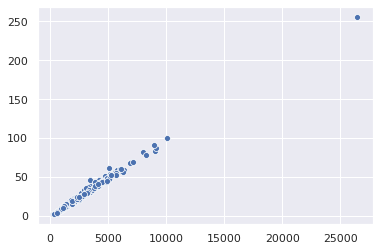

In [12]:
# nf_map = {}
# for f in eval_features:
#     if f.example_index in nf_map:
#         nf_map[f.example_index] += 1
#     else:
#         nf_map[f.example_index] = 1

# n_tokens_to_features = []
# for example in eval_examples:
#     n_tokens = len(example.doc_tokens)
#     n_features = nf_map[example.example_id]
#     n_tokens_to_features.append((n_tokens, n_features))
    
# print(pd.Series([x[0] / x[1] for x in n_tokens_to_features]).describe())

# sns.scatterplot([x[0] for x in n_tokens_to_features], [x[1] for x in n_tokens_to_features])

### **eval_features**
- `doc_span_index`: Which index this span is in the set that makes up one question-article pair
- `example_index`: Index of the example 
- `input_mask`: 0 if a token is padding, otherwise 1 for each token in the article
- `segment_ids`: Tokens that are part of a question are 0 ([CLS], [Q], ..., [SEP])
- `inpud_ids`: Token ids of the article
    - 0 -> [PAD]
    - 101 -> [CLS]
    - 102 -> [SEP]
    - 103 -> [MASK]
    - 104 -> [Q]
    - 105 -> [YES]
    - 106 -> [NO]
    - 107 -> [NoLongAnswer]
    - 108 -> [NoShortAnswer]
- `token_is_max_context`: False if this token will appear again in the next document span due to a sliding window being used, and True otherwise
- `token_to_orig_map`: Maps the tokens in `tokens` and `input_ids` to the actual token indices in the original document
- `tokens`: A list of tokens making up the document span
- `unique_id`: A unique id number for this article (NOT this document span) 

*Note - mappings are 0 indexed and exlude tokens that are part of the question (those can be identified from segment ids)

## Build the Model

In [6]:
model = build_model(model_name=FLAGS.model,
                    config_file=FLAGS.config_file,
                    max_seq_length=FLAGS.max_seq_length,
                    init_ckpt=FLAGS.init_checkpoint)
model.summary()

Model: "bert_baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
bert (BertModel)                ((None, 1024), (None 335141888   input_ids[0][0]                  
                                                                 input_mask[0][0]     

In [7]:
n_steps = np.ceil(eval_writer.num_features / FLAGS.predict_batch_size)
generator = data_generator(eval_filename, FLAGS.predict_batch_size)

preds = model.predict_generator(generator, steps=n_steps)

# Compute the Answers

In [13]:
weights = {
    'ans_type_conf_weight': 0.4,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.3,
    'conf_bias': 0.0,
    'conf_threshold': 0.97
}


id_to_example = {}
for example in eval_examples:
    id_to_example[example.example_id] = example

answers = compute_answers(preds, candidates_dict, eval_features, eval_examples, id_to_example, weights)

/home/ejmejm/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: Original to document index mapping could not be resolved!


# Compute the Micro-F1 Score

In [14]:
if FLAGS.test_post_processing:
    micro_f1, recall, precision, details = score_preds(actual_answers, answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(details)

Micro F1 Score: 0.5315068493150685
Recall: 0.9238095238095239
Precision: 0.3730769230769231
{'TP': 97, 'FP': 163, 'FN': 8, 'FP_WA': 56, 'FP_NA': 107}


In [15]:
score_preds_2(raw_examples, answers)

('TP = 95   FP = 165   FN = 7   TN = 133   F1 = 0.52',
 'TP = 62   FP = 90   FN = 4   TN = 44   F1 = 0.57',
 'TP = 33   FP = 75   FN = 3   TN = 89   F1 = 0.46')

# Grid Search to Select the Best Parameters for Postprocessing

In [16]:
if False:
    default_range = np.arange(0, 1.05, 0.5)

    weight_ranges = OrderedDict({
            'ans_type_conf_weight': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
            'start_pos_conf_weight': [0, 0.25, 0.5, 0.75, 1.0],
            'end_pos_conf_weight': [0, 0.25, 0.5, 0.75, 1.0],
            'conf_bias': [-0.5, -0.25, 0, 0.25, 0.5],
            'conf_threshold': [0.5]
        })

    combinations = list(itertools.product(*[weight_ranges[k] for k in weight_ranges.keys()]))

    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)

    results = {}
    for weight_vals in tqdm.tqdm(combinations):
        weights = {}
        for weight_name, weight_val in zip(weight_ranges.keys(), weight_vals):
                weights[weight_name] = weight_val

        tmp_answers = compute_answers(preds, candidates_dict, eval_features, weights)
        micro_f1, recall, precision, _ = score_preds(actual_answers, tmp_answers)
        results[weight_vals] = (micro_f1, recall, precision)
        
    sr = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    print(sr[:20])

# Answers Data Analysis

### Things to explore (WIP)
- Can we accurately order the answers in terms of confidence?
- Is a series of segments all with answers a good predictor for an actual answer in that block?
- What does the general spread of probabilities look like when there is an answer?
- What about the spread of probabilities when there is no answer?




- If 1, 2, and 3 are in a row, choose the middle one

In [17]:
def in_range(first, second):
    return first[0] >= second[0] and first[1] <= second[1]

In [18]:
avg_n_features = 0
ordering_reg_data = [] # (predicted rank of answer, whether there actually is answer at that feature)
n_preds_data = [] # (percent of features that predict an answer, whether there is actually an answer)

for example_id in answers.keys():
    pred_answer = answers[example_id]
    actual_answer = actual_answers[example_id]
    
    if not pred_answer['ordered_entries']:
        continue
    
    avg_n_features += id_to_example[example_id].n_features
    entries_pred = np.zeros(id_to_example[example_id].n_features, dtype=np.int32)
    actual_oh = np.zeros(id_to_example[example_id].n_features, dtype=np.int32)
    for entry_idx, entry in enumerate(pred_answer['ordered_entries']):
        feature = entry['feature']
        entries_pred[feature.doc_span_index] = entry_idx + 1
        
        tok_to_orig_map = entry['feature'].token_to_orig_map
        feature_min_idx = min(tok_to_orig_map.values(), key=lambda x: x if x != -1 else 99999)
        feature_max_idx = max(tok_to_orig_map.values())
        target_answers = actual_answer['long_answers']
        if isinstance(actual_answer['short_answers'], tuple):
            target_answers = actual_answer['short_answers']
        if target_answers:
            for tgt in target_answers:
                if in_range(tgt, (feature_min_idx, feature_max_idx)):
                    actual_oh[feature.doc_span_index] = 1
                    break
     
    percent_preds = len(pred_answer['ordered_entries']) / id_to_example[example_id].n_features
    exists_answer = int(1 in actual_oh)
    n_preds_data.append((percent_preds, exists_answer))
    
    for x, y in zip(entries_pred, actual_oh):
        if x != 0 or y != 0:
            ordering_reg_data.append((x, y))
    
    print(entries_pred)
    print(actual_oh)
    print()

print('Avg # features per example:', avg_n_features / len(answers.keys()))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[ 5  3 15 12  0  2  1  0  0  6  0 14 11  0 10  0  0  0  0  9 13  8  7  4
  0  0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[3 0 2 1 0 5 0 6 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 0 1 3 2 7 6 8 9 0 5 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 2 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 

In [11]:
import matplotlib as plt
import seaborn as sns

%matplotlib inline
sns.set()

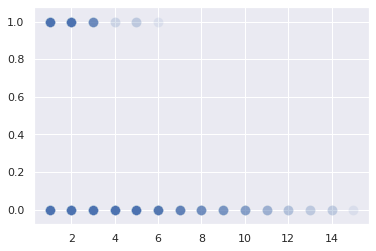

In [20]:
sns.scatterplot([x[0] for x in ordering_reg_data], [x[1] for x in ordering_reg_data], s=100, alpha=0.1)

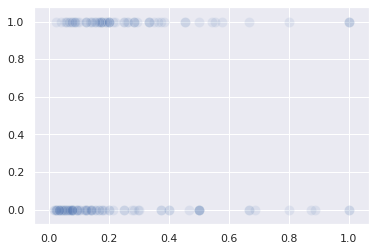

In [21]:
sns.scatterplot([x[0] for x in n_preds_data], [x[1] for x in n_preds_data], s=100, alpha=0.1)

# Generate Features for the Second Model

In [47]:
if FLAGS.do_predict:
    if FLAGS.second_model == 'bert':
        tokenizer_2 = bert_tokenization.FullTokenizer(
            vocab_file=FLAGS.second_vocab_file, do_lower_case=FLAGS.do_lower_case)
    elif FLAGS.second_model == 'albert':
        tokenizer_2 = albert_tokenization.FullTokenizer(
            None, spm_model_file=FLAGS.second_vocab_file)

    if FLAGS.test_post_processing:
        input_file = FLAGS.train_file
    else:
        input_file = FLAGS.predict_file

    eval_writer_2 = tf2baseline.FeatureWriter(
      filename=os.path.join(FLAGS.output_dir, "eval_2.tf_record"),
      is_training=FLAGS.test_post_processing)
    eval_features_2 = []
    
    def append_feature_2(feature):
        eval_features_2.append(feature)
        eval_writer_2.process_feature(feature)
    
    # Limit examples to only those that are not unknown answers
    eval_examples_2 = [example for example in eval_examples if answers[example.example_id]['long_answer']]

    for target_rank in range(8):
        # Get the document token index ranges of the desired answers
        n_extra_tokens = 30
        answer_ranges = []
        curr_examples = []
        for example in eval_examples_2:
            answer = answers[example.example_id]
            if target_rank >= len(answer['ordered_entries']):
                continue
            entry = answer['ordered_entries'][target_rank]

            doc_start_idx = entry['doc_tokens_start_idx']
            doc_end_idx = entry['doc_tokens_end_idx']

            answer_ranges.append((max(0, doc_start_idx - n_extra_tokens),
                                  min(len(example.doc_tokens), doc_end_idx + n_extra_tokens)))
            
            curr_examples.append(example)

        convert_partial_examples_to_features(
            examples=eval_examples_2,
            ranges=answer_ranges,
            tokenizer=tokenizer_2,
            is_training=FLAGS.test_post_processing,
            output_fn=append_feature_2)

    eval_writer_2.close()
    eval_filename_2 = eval_writer_2.filename

    print('# Examples (2):', len(eval_examples_2))
    print('# Features (2):', len(eval_features_2))

    print('**Features**\n')

    for e in dir(eval_features_2[0]):
        if not e.startswith('__'):
            print(e)

# Examples (2): 152
# Features (2): 473
**Features**

answer_text
answer_type
doc_span_index
end_position
example_index
input_ids
input_mask
segment_ids
start_position
token_is_max_context
token_to_orig_map
tokens
unique_id


# Build the Second Model

In [48]:
tf.keras.backend.clear_session()

model = build_model(model_name=FLAGS.second_model,
                    config_file=FLAGS.second_config_file,
                    max_seq_length=FLAGS.second_max_seq_length,
                    init_ckpt=FLAGS.second_init_checkpoint)
model.summary()

Model: "albert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 384)]        0                                            
__________________________________________________________________________________________________
albert_model (AlbertModel)      ((None, 4096), (None 222622336   input_ids[0][0]                  
                                                                 input_mask[0][0]            

# Run Predictions with the Second Model

In [49]:
n_steps = np.ceil(eval_writer_2.num_features / FLAGS.second_batch_size)
generator = data_generator(eval_filename_2, FLAGS.second_batch_size)

preds_2 = model.predict(generator, steps=n_steps)

# Compute New Answers

In [50]:
invalid_input_ids_2 = tokenizer_2.convert_tokens_to_ids(['[Q]', '[SEP]', '[CLS]', '[PAD]'])

weights_2 = {
    'ans_type_conf_weight': 0.6,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.1,
    'conf_bias': 0.0,
    'conf_threshold': 0.8
}

second_answers = compute_answers(preds_2, 
                                 candidates_dict, 
                                 eval_features_2, 
                                 eval_examples_2, 
                                 id_to_example,
                                 weights=weights_2,
                                invalid_input_ids=invalid_input_ids_2)

final_answers = copy.copy(answers)
final_answers.update(second_answers)

if FLAGS.test_post_processing:
#     actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)
    micro_f1, recall, precision, details = score_preds(actual_answers, final_answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(details)
    
    print()
    
    for x in score_preds_2(raw_examples, final_answers):
        print(x)

Micro F1 Score: 0.662379421221865
Recall: 0.824
Precision: 0.553763440860215
{'TP': 103, 'FP': 83, 'FN': 22, 'FP_WA': 36, 'FP_NA': 47}

TP = 101   FP = 85   FN = 21   TN = 193   F1 = 0.66
TP = 60   FP = 45   FN = 15   TN = 80   F1 = 0.67
TP = 41   FP = 40   FN = 6   TN = 113   F1 = 0.64


In [51]:
[{k: v for k, v in a.items() if k in ('short_answer', 'long_answer')} for a in second_answers.values()]

[{'long_answer': (2861, 2943), 'short_answer': (2893, 2906)},
 {'long_answer': (176, 245), 'short_answer': (238, 240)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (75, 186), 'short_answer': (85, 86)},
 {'long_answer': (946, 1147), 'short_answer': (972, 973)},
 {'long_answer': (83, 406), 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (323, 379), 'short_answer': (360, 364)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (603, 655), 'short_answer': (651, 653)},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (723, 827), 'short_answer': (739, 740)},
 {'long_answer': (3524, 3608), 'short_answer': (3534, 3535)},
 {'long_answer': (66, 155), 'short_answer': None},
 {'long_answer': None, 'short_answer': None},
 {'long_answer': (245, 335), 'short_answer': (246, 249)},
 {

In [28]:
simple_answers = [{k: v for k, v in a.items() if k in ('short_answer', 'long_answer')} \
    for a in second_answers.values()]

has_ans_perc = sum([1 for a in simple_answers if a['long_answer']]) / len(simple_answers)
print('Has answer percent: {:.2f}%'.format(has_ans_perc * 100))

n_la = 0
n_sa = 0
n_la_matches = 0
n_sa_matches = 0
for example_id in second_answers.keys():
    answer1 = answers[example_id]
    answer2 = second_answers[example_id]
    if answer2['long_answer']:
        n_la += 1
        if answer1['long_answer'] == answer2['long_answer']:
            n_la_matches += 1
            
    if answer2['short_answer']:
        n_sa += 1
        if answer1['short_answer'] == answer2['short_answer']:
            n_sa_matches += 1
            
print('Long answer agreement: {:.2f}%'.format(n_la_matches/n_la * 100))
print('Short answer agreement: {:.2f}%'.format(n_sa_matches/n_sa * 100))

Has answer percent: 67.11%
Long answer agreement: 83.33%
Short answer agreement: 60.76%


In [29]:
if FLAGS.test_post_processing:
    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)
    micro_f1, recall, precision, details = score_preds(actual_answers, final_answers)

    print(f'Micro F1 Score: {micro_f1}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(details)

Micro F1 Score: 0.6179401993355482
Recall: 0.775
Precision: 0.5138121546961326
{'TP': 93, 'FP': 88, 'FN': 27, 'FP_WA': 41, 'FP_NA': 47}


# Grid Search for Postprocessing Parameters

In [30]:
if False:
    weight_ranges = OrderedDict({
            'ans_type_conf_weight': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
            'start_pos_conf_weight': [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4],
            'end_pos_conf_weight': [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4],
            'conf_bias': [-0.2, -0.1, 0, 0.1, 0.2],
            'conf_threshold': [0.5]
        })

    combinations = list(itertools.product(*[weight_ranges[k] for k in weight_ranges.keys()]))

    actual_answers = get_actual_answers(FLAGS.train_file, FLAGS.n_examples)

    results = {}
    for weight_vals in tqdm.tqdm(combinations):
        weights_2 = {}
        for weight_name, weight_val in zip(weight_ranges.keys(), weight_vals):
                weights_2[weight_name] = weight_val
                
        tmp_answers = compute_answers(preds_2, 
                                      candidates_dict, 
                                      eval_features_2, 
                                      eval_examples_2, 
                                      id_to_example,
                                      weights=weights_2,
                                      invalid_input_ids=invalid_input_ids_2)
        tmp_final_answers = copy.copy(answers)
        tmp_final_answers.update(tmp_answers)
        
        micro_f1, recall, precision, _ = score_preds(actual_answers, tmp_final_answers)
        results[weight_vals] = (micro_f1, recall, precision)
        
    sr = sorted(results.items(), key=lambda x: x[1][0], reverse=True)
    print(sr[:20])

### BERT Joint Baseline
    - F1: 0.564
    - Recall: 0.850
    - Precision: 0.422
    
    On 2000 dev examples:
    - F1: 0.524
    
### BERT Joint + ALBERT Finetuned
    - F1: 0.628
    - Recall: 0.667
    - Precision: 0.593
    
    On 2000 dev examples:
    
    'ans_type_conf_weight': 0.6,
    'start_pos_conf_weight': 0.3,
    'end_pos_conf_weight': 0.1,
    'conf_bias': 0.0,
    'conf_threshold': 0.8
        
    - F1: 0.613
    
### ALBERT Finetuned
    - F1: 0.791
    - Recall: 0.895
    - Precision: 0.708

## Function to Create a Submission

In [31]:
def create_submission(answers):
    submission_data = []

    # Loop through answers in alphabetic order of example_ids
    # This is how it's sorted in the sample submission
    for example_id, answer in sorted(answers.items(), key=lambda x: x[0]):
        long_answer_text = ''
        if isinstance(answer['long_answer'], tuple):
            long_answer_text = f'{answer["long_answer"][0]}:{answer["long_answer"][1]}'
        else:
            assert answer['long_answer'] is None, 'Invalid type of long answer!'
            assert answer['short_answer'] is None, 'Cannot have a short answer with no long answer!'
        long_answer_row = [f'{example_id}_long', long_answer_text]

        short_answer_text = ''
        if isinstance(answer['short_answer'], tuple):
            short_answer_text = f'{answer["short_answer"][0]}:{answer["short_answer"][1]}'
        elif answer['short_answer'] in ('YES', 'NO'):
            short_answer_text = answer['short_answer']
        else:
            assert answer['short_answer'] is None, 'Invalid type of short answer!'
        short_answer_row = [f'{example_id}_short', short_answer_text]

        submission_data.append(long_answer_row)
        submission_data.append(short_answer_row)

    submission_df = pd.DataFrame(submission_data, columns=['example_id', 'PredictionString'])
    return submission_df

# Create and Save the Submission!

In [32]:
if not FLAGS.test_post_processing:
    submission_df = create_submission(answers)
    print(submission_df.head())
    submission_df.to_csv('submission.csv', index=False)